# XGBoost para classificação da direção de criptos

In [307]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [308]:
# Leitura dos dados
symbol = 'SOLUSDT'
period = '4h'
df = pd.read_csv(f'../../data/fechamentos/{symbol}_{period}_data.csv')

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

# Drop de colunas desnecessárias, quando o modelo é puxado pelo novo código
try:
    df.drop(columns=['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], inplace=True)
except:
    pass

# Definição do target
retorno_futuro = df['close'].shift(-1) / df['close'] - 1

limiar_lucro = 0.0005 

df['target'] = np.where(retorno_futuro > limiar_lucro, 1, 0) # 1 para retorno acima do limiar, 0 para abaixo

print(df['target'].value_counts(normalize=True))
print(df['target'].value_counts())


target
0    0.5085
1    0.4915
Name: proportion, dtype: float64
target
0    5504
1    5320
Name: count, dtype: int64


In [309]:
# Construção das features
def create_features(df):
    df = df.copy()
    epsilon = 1e-10

    # Retorno e Volatilidade
    df['return'] = df['close'].pct_change()
    df['volatility_20'] = df['return'].rolling(window=20).std()

    # Momentum
    df['momentum_10'] = df['close'].diff(10)

    # Osciladores
    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df['williams_r_14'] = williams_r(df['high'], df['low'], df['close'], period=14)

    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        loss = -delta.clip(upper=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        rs = gain / (loss + epsilon)
        return 100 - (100 / (1 + rs))
    df['rsi_14'] = rsi(df['close'], period=14)
    df['rsi_14_slope'] = df['rsi_14'].diff().rolling(window=5).mean()

    # MACD
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_slope'] = df['macd'].diff().rolling(window=5).mean()

    # Bandas de Bollinger
    rolling_mean_20 = df['close'].rolling(window=20).mean()
    rolling_std_20 = df['close'].rolling(window=20).std()
    df['bb_upper'] = rolling_mean_20 + (rolling_std_20 * 2)
    df['bb_lower'] = rolling_mean_20 - (rolling_std_20 * 2)
    df['bb_width'] = df['bb_upper'] - df['bb_lower']
    df['bb_pos'] = (df['close'] - df['bb_lower']) / (df['bb_width'] + epsilon)
    df['bb_width_normalizada'] = (df['bb_upper'] - df['bb_lower']) / df['close']

    # Volume
    price_direction = np.sign(df['close'].diff()).fillna(0)
    df['obv'] = (price_direction * df['volume']).cumsum()
    df['vol_osc'] = df['volume'].rolling(5).mean() / (df['volume'].rolling(20).mean() + epsilon)

    # Volatilidade (ATR)
    def atr(df_atr, window=14):
        tr_high_low = df_atr['high'] - df_atr['low']
        tr_high_prev_close = abs(df_atr['high'] - df_atr['close'].shift())
        tr_low_prev_close = abs(df_atr['low'] - df_atr['close'].shift())
        tr = pd.DataFrame({'hl': tr_high_low, 'hpc': tr_high_prev_close, 'lpc': tr_low_prev_close}).max(axis=1)
        return tr.rolling(window=window).mean()
    df['atr_14'] = atr(df, window=14)
    df['atr_normalizado'] = df['atr_14'] / df['close']

    # ADX (Força da Tendência)
    def adx(df_adx, period=14):
        high = df_adx['high']
        low = df_adx['low']
        close = df_adx['close']
        
        up = high.diff()
        down = -low.diff()
        
        plus_dm = np.where((up > down) & (up > 0), up, 0)
        minus_dm = np.where((down > up) & (down > 0), down, 0)

        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
        
        atr_val = tr.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        plus_di = 100 * (pd.Series(plus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))
        minus_di = 100 * (pd.Series(minus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))

        dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di + epsilon))
        adx_val = dx.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        return adx_val, plus_di, minus_di
    
    df['adx_14'], df['pdi_14'], df['ndi_14'] = adx(df, period=14)
    df['adx_14_slope'] = df['adx_14'].diff().rolling(window=5).mean()

    # Features de Interação
    df['retorno_x_vol'] = df['return'] * df['volatility_20']
    df['retorno_x_macd'] = df['return'] * df['macd']
    df['retorno_x_bb_pos'] = df['return'] * df['bb_pos']
    df['vol_x_macd'] = df['volatility_20'] * df['macd']
    df['vol_x_bb_pos'] = df['volatility_20'] * df['bb_pos']
    df['macd_x_bb_pos'] = df['macd'] * df['bb_pos']
    df['adx_x_pdi'] = df['adx_14'] * df['pdi_14']
    df['adx_x_ndi'] = df['adx_14'] * df['ndi_14']
    df['pdi_x_ndi'] = df['pdi_14'] * df['ndi_14']
    df['adx_x_macd'] = df['adx_14'] * df['macd']
    df['adx_x_bb_pos'] = df['adx_14'] * df['bb_pos']
    df['pdi_x_bb_pos'] = df['pdi_14'] * df['bb_pos']
    df['ndi_x_bb_pos'] = df['ndi_14'] * df['bb_pos']
    df['adx_x_return'] = df['adx_14'] * df['return']
    df['pdi_x_return'] = df['pdi_14'] * df['return']
    df['ndi_x_return'] = df['ndi_14'] * df['return']    
    df['macd_x_return'] = df['macd'] * df['return']
    df['bb_pos_x_return'] = df['bb_pos'] * df['return']
    df['obv_x_return'] = df['obv'] * df['return']
    df['obv_x_volatility'] = df['obv'] * df['volatility_20']
    df['obv_x_macd'] = df['obv'] * df['macd']
    df['pdi_x_macd'] = df['pdi_14'] * df['macd']
    df['ndi_x_macd'] = df['ndi_14'] * df['macd']
    df['pdi_x_adx'] = df['pdi_14'] * df['adx_14']
    df['ndi_x_adx'] = df['ndi_14'] * df['adx_14']

    # Lag Features
    lag_cols = ['return', 'volatility_20', 'macd_hist', 'bb_pos', 'retorno_x_vol', 'retorno_x_macd', 'retorno_x_bb_pos']
    for col in lag_cols:
        for lag in range(1, 4):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    df.dropna(inplace=True)
    return df
      
# Aplicação da função
df = create_features(df)
df = df.drop(columns=['open', 'high', 'low', 'volume'])

Total de amostras: 10793
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---


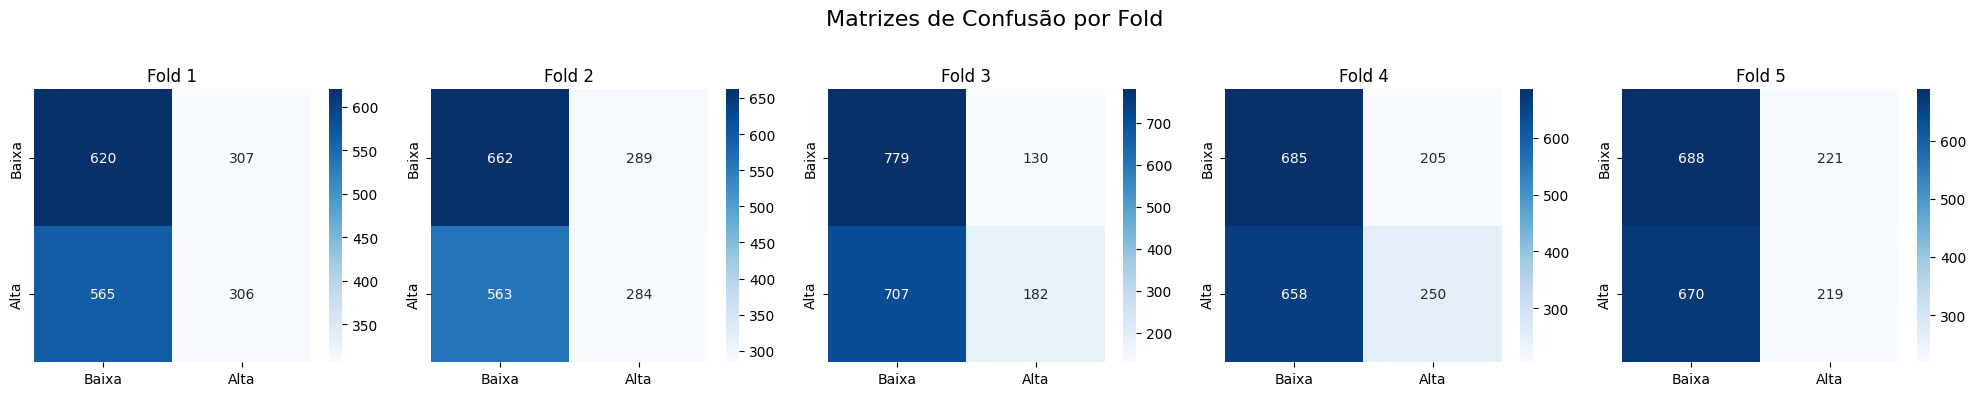


--------------------------------
| Resumo das Métricas por Fold |
--------------------------------


,Acurácia,Precisão,Recall,F1 Score,AUC
Fold,,,,,
1,0.515017,0.499184,0.351320,0.412399,0.497877
2,0.526140,0.495637,0.335301,0.400000,0.530823
3,0.534483,0.583333,0.204724,0.303081,0.528599
4,0.520022,0.549451,0.275330,0.366838,0.513361
5,0.504449,0.497727,0.246344,0.329571,0.504950


Média do AUC: 0.52

-----------------------------------
| Comparativo Visual das Métricas |
-----------------------------------


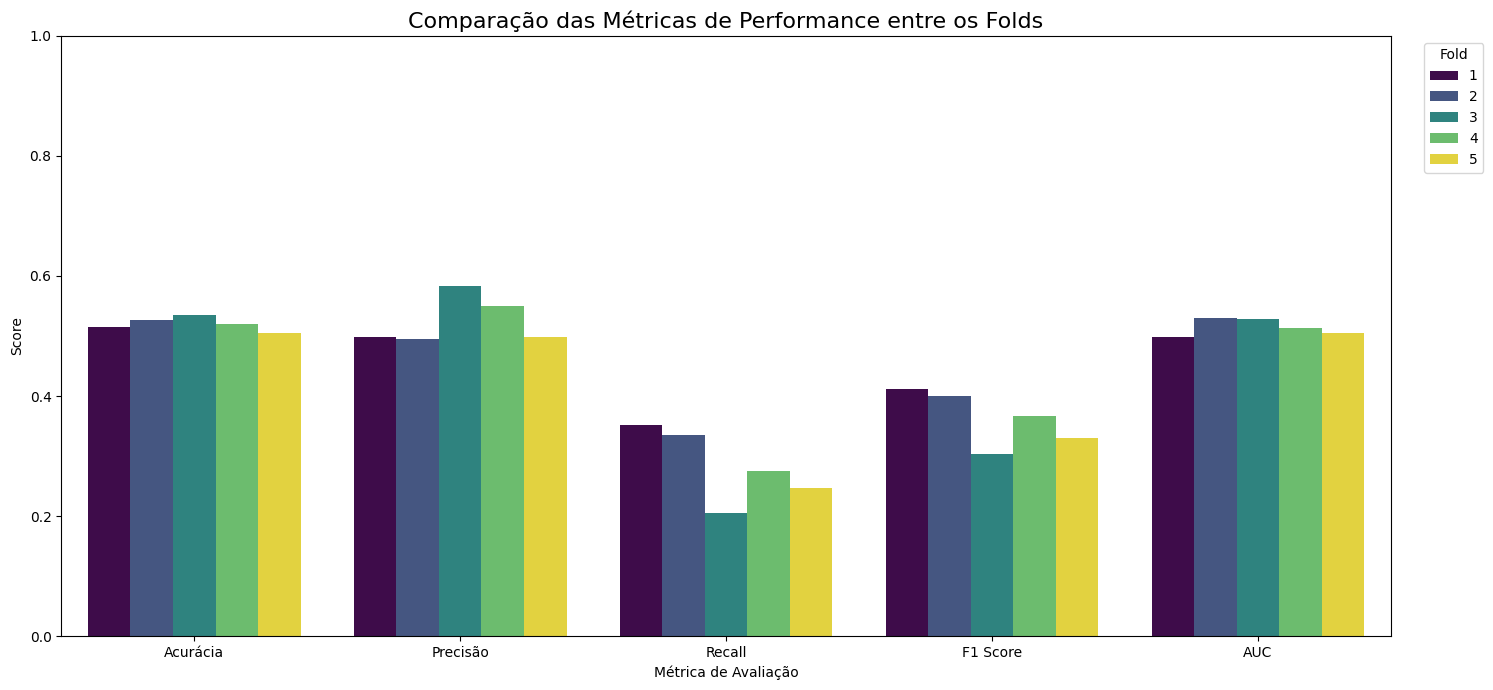

In [310]:
# Lista para armazenar os resultados de cada fold
results_list = []

# Preparação da figura para as matrizes de confusão
n_splits = 5
fig, axes = plt.subplots(1, n_splits, figsize=(20, 4))
fig.suptitle('Matrizes de Confusão por Fold', fontsize=16)

# Validação cruzada com TimeSeriesSplit
tsv = TimeSeriesSplit(n_splits=n_splits)
X = df.drop(columns=['target'])
y = df['target']

print(f"Total de amostras: {len(X)}")

for fold, (train_index, test_index) in enumerate(tsv.split(X)):
    print(f"--- Processando Fold {fold + 1}/{n_splits} ---")
    # Divisão dos dados em treino e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinamento do modelo
    model = xgb.XGBClassifier(
        n_estimators=5000, 
        objective='binary:logistic', 
        learning_rate=0.001, 
        max_depth=5, 
        scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
        subsample=0.8, 
        colsample_bytree=0.8, 
        gamma=0.1,
        early_stopping_rounds=20, 
        random_state=1
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    # Avaliação do modelo
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Armazena as métricas de avaliação em um dicionário
    fold_results = {
        'Fold': fold + 1,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_proba)
    }
    results_list.append(fold_results)

    # Plota a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[fold], 
                xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
    axes[fold].set_title(f'Fold {fold + 1}')

# Mostra as matrizes de confusão
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# DataFrame com os resultados de cada fold
results_df = pd.DataFrame(results_list)

# Toc meu de organização de print
text_1 = 'Resumo das Métricas por Fold'
print("\n" + "-"*(len(text_1)+4))
print(f'| {text_1} |')
print("-"*(len(text_1)+4))
display(results_df.set_index('Fold'))
print(f"Média do AUC: {results_df['AUC'].mean():.2f}")

text_2 = 'Comparativo Visual das Métricas'
print("\n" + "-"*(len(text_2)+4))
print(f'| {text_2} |')
print("-"*(len(text_2)+4))

# Reformata os resultados para plotagem
results_melted = results_df.melt(id_vars='Fold', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(15, 7))
sns.barplot(data=results_melted, x='Métrica', y='Valor', hue='Fold', palette='viridis')
plt.title('Comparação das Métricas de Performance entre os Folds', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Métrica de Avaliação')
plt.ylim(0, 1)
plt.legend(title='Fold', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Peso', ylabel='Features'>

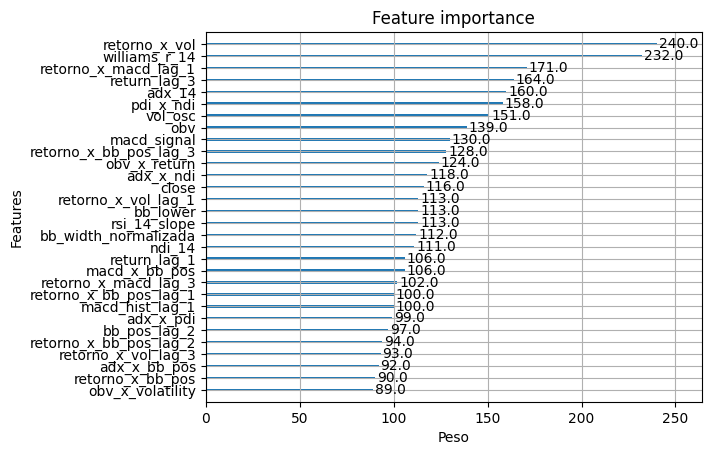

In [311]:
xgb.plot_importance(model, max_num_features=30, importance_type='weight', xlabel='Peso', ylabel='Features')

In [ ]:
def simulate_trading(df, model, initial_balance=1000, fee=0.001, 
                                    buy_threshold=0.60, sell_threshold=0.40):
    """
    Simula uma estratégia de trading.
    """
    balance = initial_balance
    position = 0  # Quantidade de ativo que você possui
    trades = []

    # O loop começa no índice 1 para podermos usar os dados de i-1
    for i in range(1, len(df)):
        
        features = df.iloc[i-1].drop('target').values.reshape(1, -1)
        
        prob_buy = model.predict_proba(features)[0, 1] 
        
        current_price = df['close'].iloc[i]
        current_time = df.index[i]

        if prob_buy > buy_threshold and balance > 0:
            amount_to_spend = balance * (1 - fee)
            position = amount_to_spend / current_price
            
            trades.append(('Buy', current_time, current_price, balance, f'Prob: {prob_buy:.2f}'))
            balance = 0
        
        elif prob_buy < sell_threshold and position > 0:
            balance = position * current_price * (1 - fee)
            trades.append(('Sell', current_time, current_price, balance, f'Prob: {prob_buy:.2f}'))
            position = 0

    # Se a simulação terminar com uma posição aberta, liquidar pelo último preço
    if position > 0:
        last_price = df['close'].iloc[-1]
        balance = position * last_price * (1 - fee)
        trades.append(('Liquidate_Final', df.index[-1], last_price, balance, 'N/A'))
        position = 0

    return trades, balance

# ------------------------------------------------------------------------------------------- #

# Configurações da Simulação
initial_balance = 1000
buy_confidence = 0.51
sell_confidence = 0.49

# Preparação dos dados
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

simulation_df = df.iloc[-365*6:].copy() 

print("\n--- INICIANDO SIMULAÇÃO SEMESTRAL ---")

# Agrupa o DataFrame por períodos de 6 meses (semestres)
semester_grouper = simulation_df.groupby(pd.Grouper(freq='6MS'))

current_balance = initial_balance
all_trades = []
results_summary = []

# Loop para cada semestre encontrado
for semester_start_date, semester_df in semester_grouper:
    if len(semester_df) < 2:
        continue # Pula semestres sem dados suficientes

    semester_initial_balance = current_balance

    print(f"  Simulação para o Semestre começando em {semester_start_date.date()}")
    print(f"Saldo Inicial do Semestre: {semester_initial_balance:.2f} USDT")

    # Executa a simulação apenas para os dados do semestre atual
    trades, semester_final_balance = simulate_trading(
        semester_df, 
        model,
        initial_balance=semester_initial_balance,
        buy_threshold=buy_confidence,
        sell_threshold=sell_confidence
    )

    # Armazena e exibe os resultados do semestre
    semester_return = ((semester_final_balance - semester_initial_balance) / semester_initial_balance) * 100
    print(f"Saldo Final do Semestre: {semester_final_balance:.2f} USDT")
    print(f"Retorno do Semestre: {semester_return:.2f}%")
    
    if not trades:
        print("Nenhuma transação realizada neste semestre.")
    else:
        print("\nTransações do Semestre:")
        for trade in trades:
            print(f"  - {trade[0]} em {trade[1].strftime('%Y-%m-%d %H:%M')}: Preço {trade[2]:.2f}, Saldo {trade[3]:.2f}, {trade[4]}")
    
    # Atualiza o saldo para o próximo semestre e guarda os resultados
    current_balance = semester_final_balance
    all_trades.extend(trades)
    results_summary.append({
        "Semestre": semester_start_date.date(),
        "Saldo Inicial": semester_initial_balance,
        "Saldo Final": semester_final_balance,
        "Retorno (%)": semester_return
    })

# Exibe o resumo de cada semestre em uma tabela
results_table = pd.DataFrame(results_summary)
print(results_table.to_string(index=False))

total_return = ((current_balance - initial_balance) / initial_balance) * 100
print("\n--- Resumo Final ---")
print(f"Saldo Inicial Total: {initial_balance:.2f} USDT")
print(f"Saldo Final Total: {current_balance:.2f} USDT")
print(f"Retorno Total no Período: {total_return:.2f}%")
print(f"Total de Transações: {len(all_trades)}")
print("--- Fim da Simulação ---")



--- INICIANDO SIMULAÇÃO SEMESTRAL ---
  Simulação para o Semestre começando em 2024-07-01
Saldo Inicial do Semestre: 1000.00 USDT
Saldo Final do Semestre: 1179.77 USDT
Retorno do Semestre: 17.98%

Transações do Semestre:
  - Buy em 2024-07-23 20:00: Preço 173.03, Saldo 1000.00, Prob: 0.51
  - Sell em 2024-08-03 04:00: Preço 151.64, Saldo 874.63, Prob: 0.49
  - Buy em 2024-08-03 08:00: Preço 152.38, Saldo 874.63, Prob: 0.52
  - Sell em 2024-08-05 16:00: Preço 128.76, Saldo 737.58, Prob: 0.49
  - Buy em 2024-08-07 20:00: Preço 144.77, Saldo 737.58, Prob: 0.53
  - Sell em 2024-08-12 08:00: Preço 150.25, Saldo 763.97, Prob: 0.49
  - Buy em 2024-08-16 16:00: Preço 140.94, Saldo 763.97, Prob: 0.51
  - Sell em 2024-08-21 12:00: Preço 140.36, Saldo 759.30, Prob: 0.49
  - Buy em 2024-08-24 08:00: Preço 157.34, Saldo 759.30, Prob: 0.51
  - Sell em 2024-11-21 00:00: Preço 235.82, Saldo 1135.76, Prob: 0.49
  - Buy em 2024-11-26 00:00: Preço 237.45, Saldo 1135.76, Prob: 0.51
  - Sell em 2024-11-27